# Heat Sink Surface Defect Semantic Segmentation

## Packages

In [23]:
import tensorflow as tf
import numpy as np
import keras

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

## Dataset

In [2]:
import os
import imageio

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_list = os.listdir('./Heat_Sink_Surface_Defect_Dataset/images')
mask_list = os.listdir('./Heat_Sink_Surface_Defect_Dataset/labels')
image_list = ['./Heat_Sink_Surface_Defect_Dataset/images/'+i for i in image_list]
mask_list = ['./Heat_Sink_Surface_Defect_Dataset/labels/'+i for i in mask_list]

#### Take a look at some pictures

Text(0.5, 1.0, 'Mask')

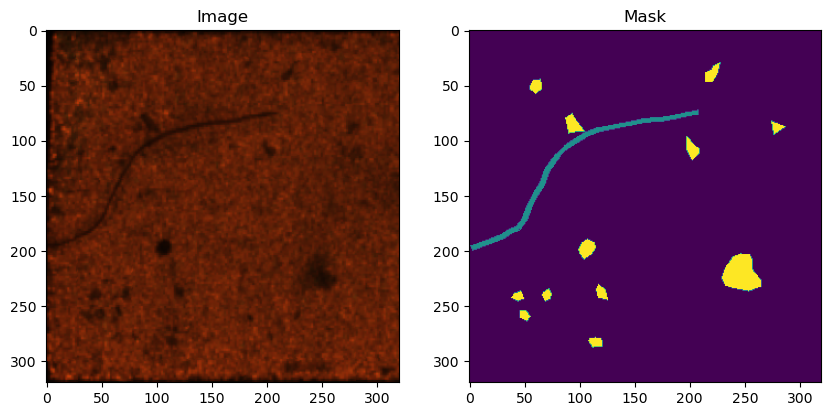

In [4]:
N = 116
img = imageio.v3.imread(image_list[N])
mask = imageio.v3.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

#### Explore dataset a bit

In [5]:
# mask_mat = np.zeros([320, 320, 1000])
# for i, mask in enumerate(mask_list):
#     m = tf.io.read_file(mask)
#     m = tf.image.decode_png(m, channels=3)
#     mask_mat[:, :, i] = tf.squeeze(tf.math.reduce_max(m, axis=-1, keepdims=True))
    
# np.unique(mask_mat, return_counts = True)    

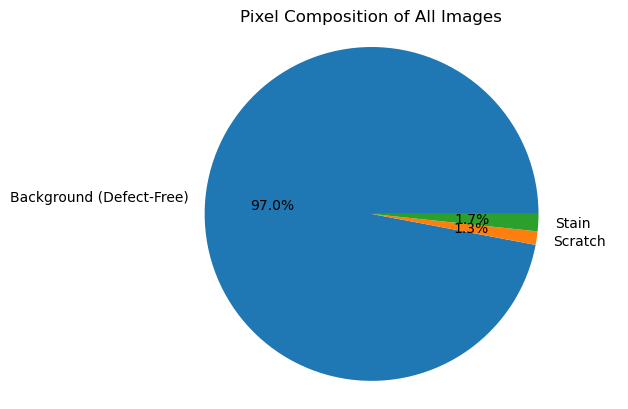

In [6]:
# Pie chart of pixels
labels = 'Background (Defect-Free)', 'Scratch', 'Stain'
sizes = [99357441, 1333995, 1708564]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')

ax1.set_title("Pixel Composition of All Images")

plt.show()

In [7]:
# mask_mat_re = np.reshape(mask_mat, (-1, 1000))

# mask_unique = []

# for i in range(1000):
#     mask_unique.append(tuple(set(mask_mat_re[:, i])))

    
    
# from collections import Counter

# Counter(mask_unique)

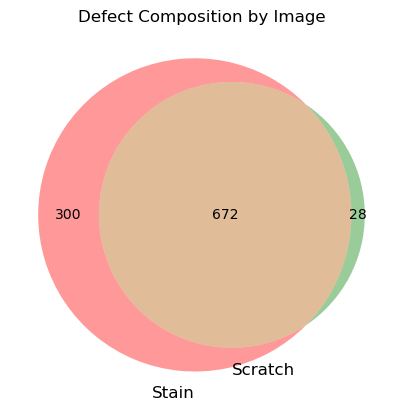

In [8]:
from matplotlib_venn import venn2

venn2(subsets = (300, 28, 672), set_labels = ('Stain', 'Scratch'))

plt.title("Defect Composition by Image")
plt.show()

#### Define Datasets

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(image_list, mask_list, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

image_filenames_train = tf.constant(X_train)
masks_filenames_train = tf.constant(Y_train)
image_filenames_val = tf.constant(X_val)
masks_filenames_val = tf.constant(Y_val)

dataset_train = tf.data.Dataset.from_tensor_slices((image_filenames_train, masks_filenames_train))
dataset_val = tf.data.Dataset.from_tensor_slices((image_filenames_val, masks_filenames_val))

#### Preprocess Data

In [14]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## U-Net

### Contracting Block

In [19]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters,
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)     
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### Upsampling Block

In [20]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    
    return conv

### Put Model Together

In [21]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=3):

    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [22]:
unet = unet_model((256, 256, 3))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_10[0][0]']              
                                )                                                             

                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_26[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_27[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 3)  99          ['conv2d_28[0][0]']              
                                                                                                  
Total params: 8,639,811
Trainable params: 8,639,811
Non-trainable params: 0
_________________________________

#### Loss Function

In [24]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [31]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

plt.plot(model_history.history["accuracy"])

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/40
22/22 [==============================] - 28s 735ms/step - loss: 0.1116 - accuracy: 0.9733
Epoch 2/40
22/22 [==============================] - 13s 582ms/step - loss: 0.1087 - accuracy: 0.9730
Epoch 3/40
22/22 [==============================] - 12s 565ms/step - loss: 0.1113 - accuracy: 0.9728
Epoch 4/40
22/22 [==============================] - 13s 570ms/step - loss: 0.1038 - accuracy: 0.9735
Epoch 5/40
22/22 [==============================] - 13s 575ms/step - loss: 0.0983 - accuracy: 0.9739
Epoch 6/40
22/22 [==============================] - 13s 572ms/step - loss: 0.0963 - accuracy: 0.9741
Epoch 7/40
22/22 [==============================] - 13s 588ms/step - loss: 0.0959 - accuracy: 0.9742
Epoch 8/40
22/22 [==============================] - 13s 575ms/step - loss: 0.0958 - accuracy: 0.9740
Epoch 9/40
22/22 [==============================] - 13s 586ms/step - 

In [42]:
# unet.save('unet_train_model_256')

INFO:tensorflow:Assets written to: unet_train_model_256\assets


INFO:tensorflow:Assets written to: unet_train_model_256\assets


In [ ]:
# unet = keras.models.load_model("unet_model")

In [35]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [36]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [37]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 45ms/step


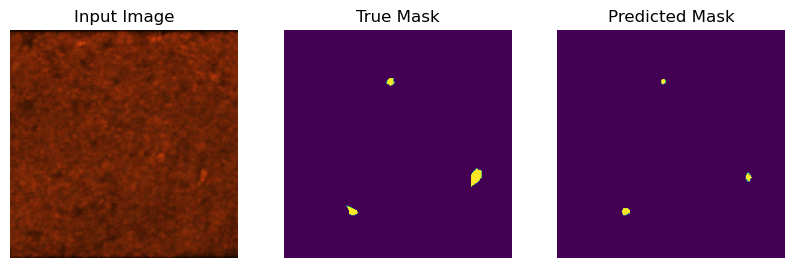

1/1 [==============================] - 0s 41ms/step


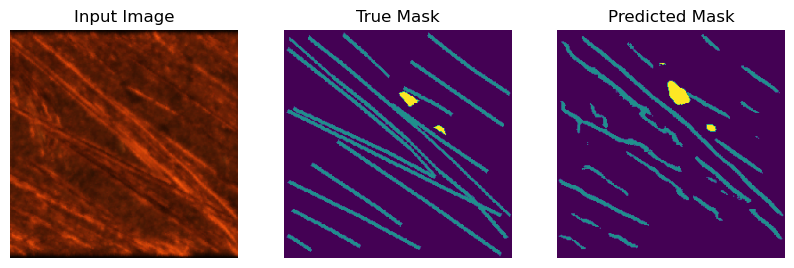

1/1 [==============================] - 0s 37ms/step


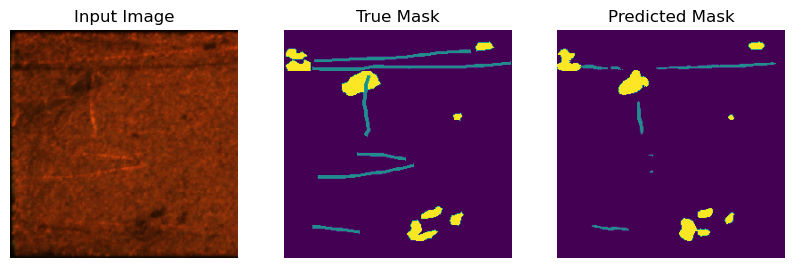

1/1 [==============================] - 0s 36ms/step


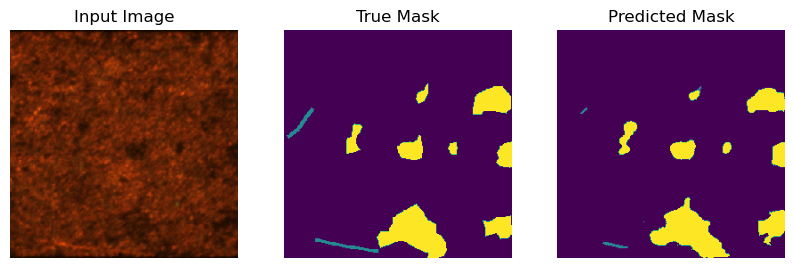

1/1 [==============================] - 0s 35ms/step


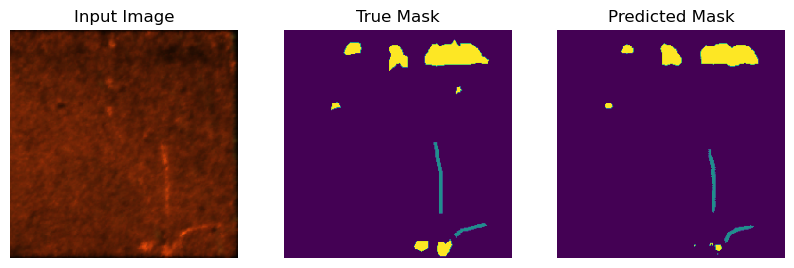

1/1 [==============================] - 0s 35ms/step


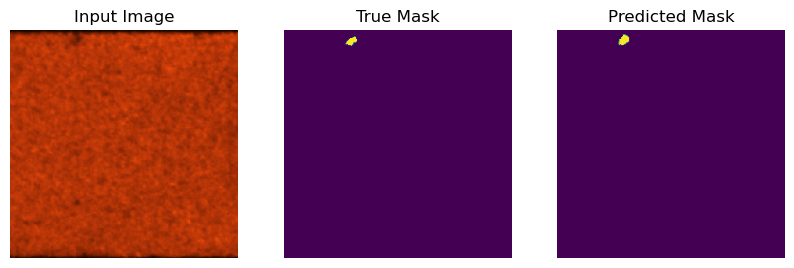

In [38]:
show_predictions(train_dataset, 6)

1/1 [==============================] - 0s 49ms/step


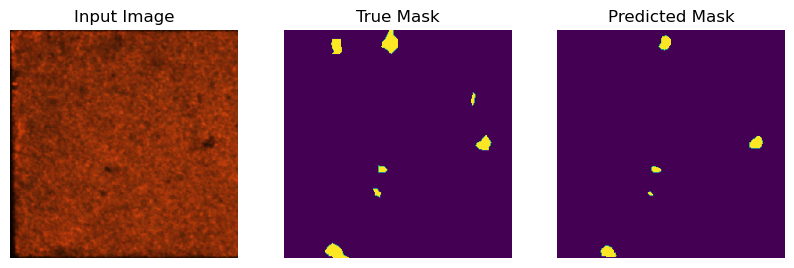

1/1 [==============================] - 0s 38ms/step


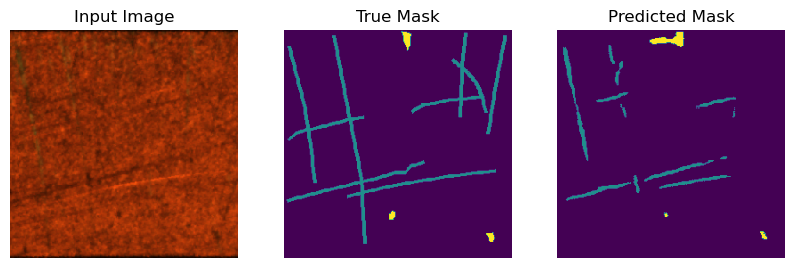

1/1 [==============================] - 0s 42ms/step


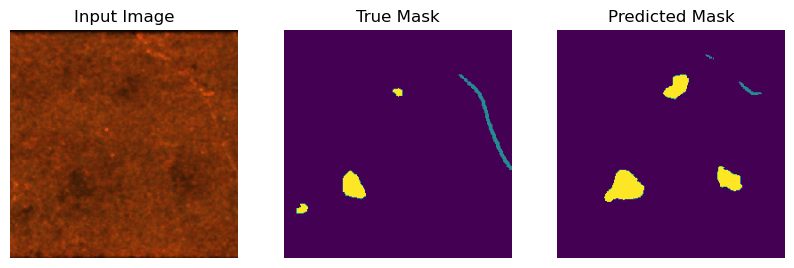

1/1 [==============================] - 0s 73ms/step


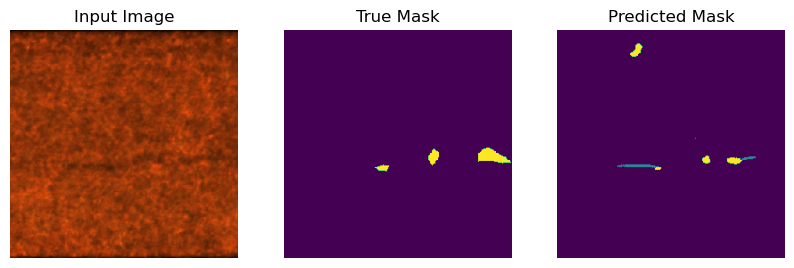

1/1 [==============================] - 4s 4s/step


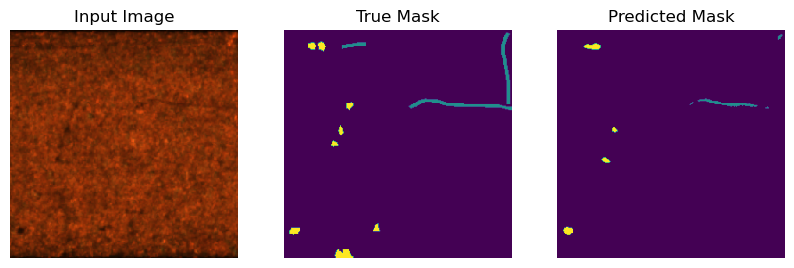

In [41]:
image_ds_val = dataset_val.map(process_path)
processed_image_ds_val = image_ds_val.map(preprocess)

val_dataset = processed_image_ds_val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

show_predictions(val_dataset, 6)